# VO9 Monte Carlo Simulations

In [1]:
import numpy as np
import random
import math

import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

## Weather Markov Chain

In [2]:
class MarkovChain(object):
    def __init__(self, states, trans_matrix):
        self.trans_matrix = trans_matrix
        self.states = states
        self.trans_prob = {}
        
        for i in range(len(states)):
            assert round(sum(trans_matrix[i]), 2) == 1
            self.trans_prob[states[i]] = dict(zip(states, trans_matrix[i]))
            
        self.chain = np.random.choice(states)

    def init_chain(self):
        return [self.chain]
            
    def next_state(self, curr_state):
        return np.random.choice(states, p = [
            self.trans_prob[curr_state][state] for state in states])
    
    def gen_chain(self, chain, iterations):
        for _ in range(iterations):
            chain.append(self.next_state(chain[-1]))            
        return chain

In [3]:
states = ["sunny", "cloudy", "rainy"]

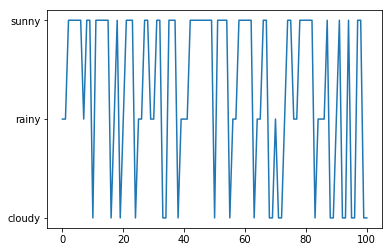

In [4]:
trans_matrix = [
    [0.7, 0.2, 0.1],
    [0.3, 0.4, 0.3],
    [0.4, 0.1, 0.5]
]

mc = MarkovChain(states, trans_matrix)
chain = mc.init_chain()
chain = mc.gen_chain(chain, 100)

plt.plot(chain)
plt.show()
plt.close()

lets generate more stable weather...


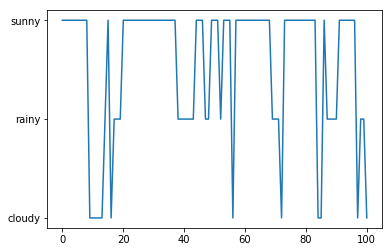

In [5]:
print("lets generate more stable weather...")
trans_matrix = [
    [0.8, 0.15, 0.05],
    [0.2, 0.6, 0.2],
    [0.3, 0.05, 0.65]
]

mc = MarkovChain(states, trans_matrix)
chain = mc.init_chain()
chain = mc.gen_chain(chain, 100)

plt.plot(chain)
plt.show()
plt.close()

## Continous State Markov Chain

In [21]:
class ContinousMarkovChain(object):
    def __init__(self):
        self.fist_elem = random.gauss(1,1)
        self.check_transition_prob()

    def init_chain(self):
        return [self.fist_elem]
            
    def transition_prob(self, x, y):
        return np.exp(-(y-x)**2/2)/np.sqrt(2*np.pi)
    
    def check_transition_prob(self):
        length = 1000000
        x_axis = 20
        x = random.gauss(1,1)
        count = 0
        print("run transition probability funciton check")

        for i in tqdm(range(length)):
            if(self.transition_prob(x, random.random()*x_axis-5) >= random.random()):
                count += 1
               
        print(round(x_axis*count/length, 2))
        assert round(x_axis*count/length, 2) == 1
        print("check successful")
        
    def next_state(self, curr_state):
        while(True):
            next_state = random.gauss(1,1)
            if (self.transition_prob(next_state, curr_state) >= random.random()):
                return next_state
    
    def gen_chain(self, chain, iterations):
        for _ in range(iterations):
            chain.append(self.next_state(chain[-1]))            
        return chain

run transition probability funciton check



1.0
check successful


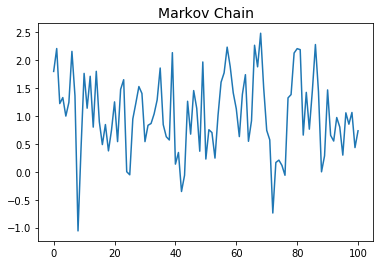

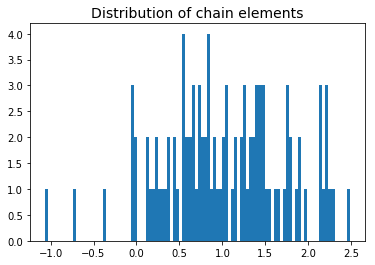

In [22]:
cmc = ContinousMarkovChain()
chain = cmc.init_chain()
chain = cmc.gen_chain(chain, 100)

plt.title("Markov Chain", fontsize=14)
plt.plot(chain)
plt.show()
plt.close()

plt.title("Distribution of chain elements", fontsize=14)
plt.hist(chain, bins=100)
plt.show()
plt.close()

## Ising Model

http://stanford.edu/~jeffjar/statmech2/intro4.html

Model system for understanding phase transitions.


Useful for helping us think about all sorts of behaviors relating to phase transitions. For instance:
- the Ising model exhibits symmetry breaking in low-temperature phase
- it has a special ‘critical point’ at a well-defined temperature (f.e. phase diagram of water)

Exactly solvable model which lets us compute thermodynamic quantities and interpret them.

In [216]:
def print_x(x):
    for i in range(len(x)):
        print(" ".join([" %i" % i if i == 1 else "%i" % i for i in x[i]]))
    return None

def picture_x(x, i=-2):
    ''' This modules plts the configuration once passed to it along with time etc '''
    X, Y = np.meshgrid(range(len(x)), range(len(x)))
    
    figsize = 2
    if(len(x) > 20):
        figsize += 1
    if(len(x) > 40):
        figsize += 1
    fig = plt.figure(figsize=(figsize, figsize), dpi=80)  # create a figure object
    ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if(i >= 0):
        plt.title("iteration: %i" % i)
    if(i == -1):
        plt.title("Start configuration")
    plt.pcolormesh(X, Y, x, vmin=-1., vmax=1., cmap=plt.cm.RdBu);
    plt.show()
    plt.close()

def corr_index(idx, size):
    if(idx == size):
        return 0
    elif(idx == -1):
        return size-1
    else:
        return idx

# hamiltonian: external field + interaction between particles
# In the case of electrons:
# - External field: B is the difference in energy between spin up and down
# - Interaction: ferromagnetic: J = 1, anti-ferromagnetic: J = -1
def hamiltonian(curr_x, x, i, j, size, B, J, triangular=True):
    # triangular lattice, can be changed to square lattice
    if(triangular):
        sum_of_pairs = curr_x*(
            x[(i+1)%size, (i+1)%size] + x[(i+1)%size, i] + x[(i-1)%size, i] +
            x[i, (i+1)%size] + x[i, (i-1)%size] + x[(i-1)%size, (i-1)%size])
    else:
        sum_of_pairs = curr_x*(
            x[(i+1)%size, i] + x[(i-1)%size, i] +
            x[i, (i+1)%size] + x[i, (i-1)%size])

    return -B*curr_x -J*sum_of_pairs*2

# randomly sweep over all positions to random interaction of 
# particles (f.e. electrons) in the system (lattice)
def sweep(x, size, accept, itr, B, J, triangular=True):
    for _ in range(size*size):
        itr +=1
        i, j = np.random.randint(0, size), np.random.randint(0, size)
        
        r = np.exp(hamiltonian(x[i, j], x, i, j, size, B, J, triangular)/(k_B*T))
        if(random.random() < min(1, r)):
            accept +=1
            x[i,j] *= -1

    return x, accept, itr

0.06666666666666667


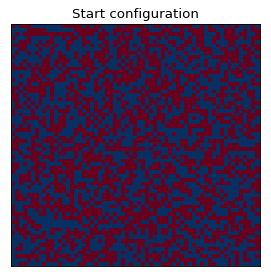

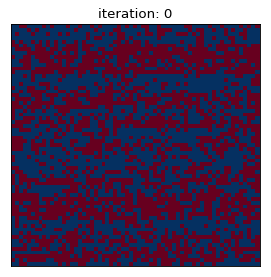

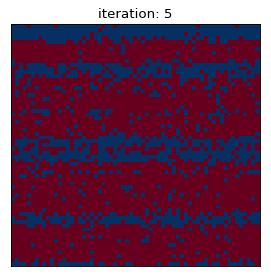

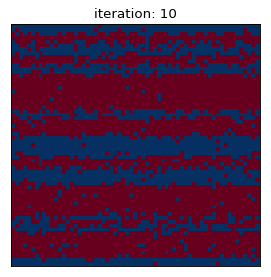

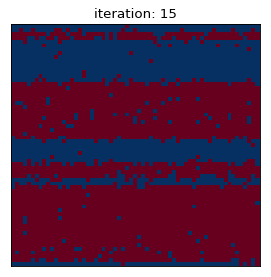

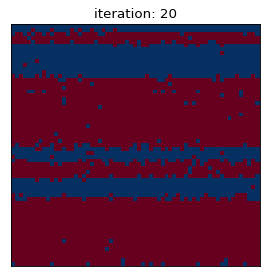

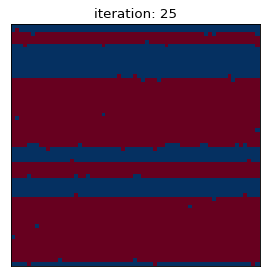


warmup accept/itr: 0.189469


In [221]:
size = 64
# len_warmup = 1000
# len_sweep= 10000

B = 0
J = 1

k_B = 1 #1.3806*10e-23
start_t = 3 #293.15
end_t = 1
length = 30

T = start_t
delta_t = (start_t-end_t)/length
print(delta_t)

# create square lattice, each element can be in one of two states (-1 or 1)
# -1, 1 can be interpreted as electron spin, one of two elements
# of a material, gas particle or no gas particle
x = np.random.choice([-1, 1], size=(size, size))
picture_x(x, -1)

accept, itr = 0, 0
for i in tqdm(range(length+1)):
    T -= delta_t
    x, accept, itr = sweep(x, size, accept, itr, B, J, triangular=False)
    if(i%5 == 0 and i < 30):
        picture_x(x, i)
    if(i%25 == 0 and i >= 30):
        picture_x(x, i)
print("warmup accept/itr: %f" % (accept/itr))

In [ ]:
# print_x(x)

# # warmup phase
# accept, itr = 0, 0
# for i in tqdm(range(len_warmup)):
#     x, accept, itr = sweep(x, size, accept, itr, B, J)
# print("warmup accept/itr: %f" % (accept/itr))
# print_x(x)

# # sweep phase
# accept, itr = 0, 0
# for i in tqdm(range(len_sweep)):
#     x, accept, itr = sweep(x, size, accept, itr, B, J)
# print("sweep accept/itr: %f" % (accept/itr))
# print_x(x)